# Training / Test Data - Crossfold Validation

Steve Pittard wsp@emory.edu (citations to other sources are inline) 

> Predictive power is assessed using metrics computedfrom a holdout set or using cross-validation (Stone,1974; Geisser,1975)

> Testing the procedure on the data that gave it birth is almost certain to overestimate performance” (Mosteller and Tukey,1977).


Before we get in the weeds with Cross fold validation let's consider the "dummy" model. Think of the dummy model as
the model that we must beat! I mean we could always do someting like estiamte the *mpg* of any car as being the average
of the **mpg** column found in the **mtcars** data set but would that be reasonable? Probably not but it's a baseline
model that we could say is perhaps the "on average" model. So then, any model we build MUST consistently produce less 
Out-of-sample / test error than the Dummy model - else we cannot say it is any good.


## Dummy Model

In machine learning, the term "dummy model" or "null model" refers to a simple, baseline model that serves as a reference point for comparing the performance of more complex models. The dummy model is typically straightforward and might not involve any learning from the data. It provides a baseline against which the performance of more sophisticated models can be measured.

There are different types of dummy models, and their choice depends on the nature of the problem. Here are a few common types:

1) Zero Rule (ZeroR): This is the simplest form of a dummy model where predictions are based solely on the majority class in a classification problem or the mean/median in a regression problem. It doesn't consider any features from the input data.

2) Random Model: This dummy model generates predictions randomly, either following the distribution of the classes in a classification problem or using a random value within the range of target values in a regression problem.
   
3) Mean/Median Model: For regression problems, a dummy model might predict the mean or median of the target variable for all instances. This provides a baseline for comparison, and any more complex model should at least outperform this simple average.

4) Stratified Model: In classification problems, a dummy model might predict the class distribution of the training set. For example, if 70% of the instances belong to class A and 30% to class B, the dummy model would predict class A for 70% of the instances and class B for 30%.
The purpose of using a dummy model is to establish a baseline performance level. Any advanced machine learning model should demonstrate superior performance compared to the dummy model. If a complex model cannot outperform the dummy model, it suggests that there may be issues with the model, data, or the problem itself that need further investigation.

## Relationship to NULL Hypothesis

In statistical hypothesis testing, the concept of the null hypothesis is closely related to the idea of a dummy or null model in machine learning. Both involve establishing a baseline or default assumption against which observations or predictions are compared.

**Null Hypothesis (in Statistics):**
In statistical hypothesis testing, the null hypothesis (often denoted as H0) is a statement that there is no significant difference or effect. It serves as a default assumption or baseline that researchers aim to test against. The null hypothesis typically represents the status quo or the absence of an effect.

For example, in the context of comparing two groups, the null hypothesis might state that there is no difference between the means of the two groups. The goal is to collect evidence against the null hypothesis and determine whether there is enough evidence to reject it in favor of an alternative hypothesis.

**Relation to Dummy Model:**
The null hypothesis in statistics shares a conceptual similarity with the dummy model in machine learning. Both represent a baseline assumption or model that assumes no underlying pattern or effect in the data.

- **Null Hypothesis (Statistics):** Assumes no effect or difference.
- **Dummy Model (Machine Learning):** Represents a simple, baseline model that often makes predictions based on simplistic rules, such as predicting the majority class or the mean/median value.

In a way, the null hypothesis can be considered a form of a dummy model in the context of statistical hypothesis testing. It provides a reference point, and the goal is to assess whether the observed data provides enough evidence to reject the null hypothesis in favor of an alternative hypothesis, which suggests the presence of a meaningful effect or pattern. In machine learning we need to build a model(s) whose performance (as determined by some metric, significantly exceeds the performance of the NULL model.

Both the null hypothesis in statistics and the dummy model in machine learning are essential for establishing a baseline for comparison and making informed decisions about the significance of observed patterns or model performance.

## Implement a Dummy Model

So in our previous case (last week) how does any of this compare to the so called "dummy" or "null" model wherein we simply estimate the **mpg** for any data as simply being the mean of the **mpg** in the training data ? Python has an "estimator" called "DummyRegressor" to do this. 

Technically we don't need this since it might be easier to just write some code to do it ourselves but the function accomodates all the methods (e.g. predict, score) that go along with any predicive method in scikit. We are jumping ahead a little bit but it's just to show what a baseline level of performance might look like. 


In [124]:
import pandas as pd
# Read in some data
url = "https://raw.githubusercontent.com/steviep42/bios534_spring_2020/master/data/mtcars.csv"

# Setup some helpful tools
import pandas as pd
mtcars = pd.read_csv(url)


In [125]:
from sklearn.dummy import DummyRegressor

# Get some training and testing data
dum_train = mtcars.loc[train.index,:]
dum_test  = mtcars.loc[test.index,:]

X_dum_train = dum_train.drop('mpg',axis=1)
y_dum_train = dum_train.mpg

X_dum_test = dum_test.drop('mpg',axis=1)
y_dum_test = dum_test.mpg


# Use the DummyRegressor
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_dum_train,y_dum_train)

# Test Preds
y_test_dum_preds = dummy.predict(X_dum_test)
rmse(y_dum_test,y_test_dum_preds)


5.695

### Create a Function To Implement Dummy Regression (well kind of)

So let's do something similar to what we did in the last notebook where we sampled the mtcars data frame using some proportion after which we created training and test data. Then we applied some model (linear regression) and subsequently observed training and testing error. We'll do much the same here but use the Dummy regressor

In [126]:
def sample_and_model(prop=.60):
    from sklearn.dummy import DummyRegressor

    # Sample some number of rows from mtcars
    dum_train = mtcars.sample(frac=prop)
    dum_test  = mtcars.drop(train.index)
   
    X_dum_train = dum_train.drop('mpg',axis=1)
    y_dum_train = dum_train.mpg

    X_dum_test = dum_test.drop('mpg',axis=1)
    y_dum_test = dum_test.mpg


    # Use the DummyRegressor
    dummy = DummyRegressor(strategy="mean")
    dummy.fit(X_dum_train,y_dum_train)

    # Train Preds

    y_train_dum_preds = dummy.predict(X_dum_train)
    train_rmse = rmse(y_dum_train,y_train_dum_preds)

    # Test Preds
    y_test_dum_preds = dummy.predict(X_dum_test)
    test_rmse = rmse(y_dum_test,y_test_dum_preds)
    
    return test_rmse, train_rmse, prop
    

In [127]:
# Let's do a 60/40 split
sample_and_model(prop=.60)

(5.736, 5.781, 0.6)

### Do Multiple Simulations of the Same Proportions

So we'll borrow the code from notebook 3 that let's us try out 100 versions of training and test data at a 70/30 split

Text(0.5, 1.0, 'Training vs Test RMSE - Dummy Model - 100 iterations')

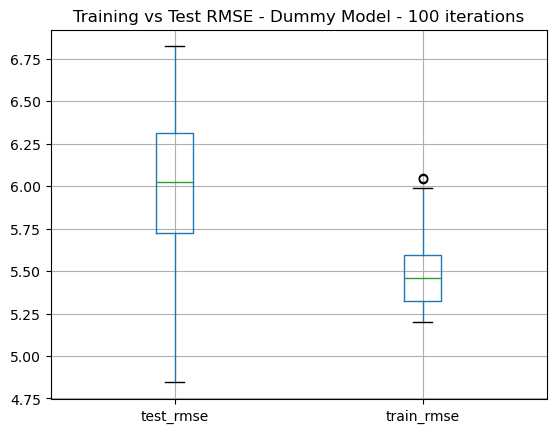

In [128]:
import numpy as np

# Use a list comprehension to capture 100 executions of sample_and_model
arr  = [ sample_and_model(.7) for ii in range(0,100) ]

# Print the first 5 rows of the arr list
arr[0:5]

df = pd.DataFrame(arr,columns=["train_rmse","test_rmse","proportion"])
df.head()
df.boxplot(['test_rmse','train_rmse'])
plt.title("Training vs Test RMSE - Dummy Model - 100 iterations")

### Try Different Proportions

So we'll borrow the code from notebook 3 that let's us try out 100 versions of training and test data at a series of proportions ranging from 0.6 to 0.9


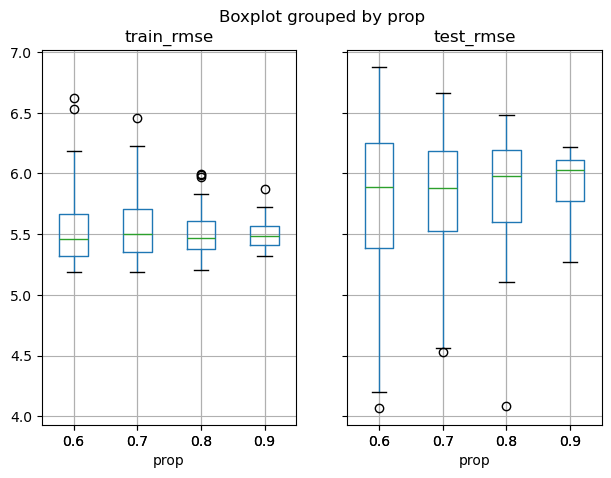

In [129]:
def train_tester(input,iterations):
    
    colnames = ['train_rmse','test_rmse','prop']
    iterations = 100 
    dflist = []
 
    for ii in range(len(input)):
        dflist.append(pd.DataFrame([sample_and_model(input[ii]) for i in range(0,iterations)],columns = colnames))

    total = pd.concat(dflist)
    return total

total = train_tester([.6,.7,.8,.9],100)
total.boxplot(['train_rmse','test_rmse'],by='prop',figsize=(7,5))
plt.show()

## Summary 

So we've been looking at the idea of splitting up our data frame, mtcars, into two different groups with the first being called **training** and the second being called **test**. The idea was simple

1) Train our regression model on the training data, use the model to make predictions using the test data and then observe the RMSE value.
2) Using the model in number 1, make predictions using the test data and then observe the RMSE value.

The first iteration of this procedure was to simply take the first 22 records of mtcars, train a model on that, and then use the resulting model to make predictions on the test data. But then we considered that maybe the data was in a certain row order which could make it possible for the first part of the data frame to have outliers. Or, it could be that the test data could have the outliers. So we then did some random sampling to make the training data more random and less susceptible to having outliers. 

Finally we experimented with chopping up the mtcars data frame into training and testing data frames according to an 80 percent / 20 percent proportion respectively. We also looked at other proportions.


<img src="pics/train_test.png" width ="500" height=500>


In [130]:
import pandas as pd
# Read in some data
url = "https://raw.githubusercontent.com/steviep42/bios534_spring_2020/master/data/mtcars.csv"

# Setup some helpful tools
import pandas as pd
mtcars = pd.read_csv(url)


https://www.stat.berkeley.edu/~aldous/157/Papers/shmueli.pdf

Let’s extend this idea of training and test splits. Remember, our goal is to generate a robust model that better estimates out-of-sample error. We can do this by resampling our data set in a way that allows us to learn from the data but not so much so that it follows the data set too closely.

We can take a single data set and partition / split it into a number of train / test subsets. We just did that in the earlier section but we only did it once. If we do this a number of times we hope we are training our model more effectively.

What would the RMSE look like if we created say K number of subsets of the data frame and selectively held out each of the K subsets, built a model on the combined remaining subsets, and then tested the model on the holdout ? We would then average the RMSE to get an idea of its variation. The series of sequential steps would be as follows:

```  
  Subset the data frame into k groups 
  For each subset:
     Consider the subset as a "hold out"" or test data set
     Combine the remaining subsets as a training data set
     Fit a model on the combined training set 
     Evaluate the model using the holdout test set
     Save the evaluation score (e.g. RNSE)

  Summarize evaluation score (e.g. mean, MSE, RMSE, etc)
```

This is called K-Fold Cross Validation. A general view of this procedure is depicted in the following figure which shows a 5 Fold scenario.

<img src="pics/folds_cv_latex.png" width ="700" height=700>

## Advantages

So if we just split the data into one training and testing data set, whatever loss metric we might use to calculate the error might be drastically different between the training and testing data sets. I mentioned this previously. 

But by using the above approach we are systematically creating variations of the training and testing data.  This improves the likelihood that we get an unbiased estimate of the Out-Of-Sample error using the RMSE metric.


## Basic Example

Example taken from https://machinelearningmastery.com/k-fold-cross-validation/
Consider a list of numbers. Say that this represents a column of data. We want to chop this list up into three folds.

```
[0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
```

This could look like:

```
Fold1: [0.5, 0.2]
Fold2: [0.1, 0.3]
Fold3: [0.4, 0.6]
```

We could then use this information to train three models as follows.
These models are trained and evaluated with each fold given a chance to be the test set.

For example:

    Model1: Trained on Fold1 + Fold2, Tested on Fold3
    Model2: Trained on Fold2 + Fold3, Tested on Fold1
    Model3: Trained on Fold1 + Fold3, Tested on Fold2

The models are then discarded after they are evaluated as they have served their purpose.

The skill scores are collected for each model and summarized for use.

## Cross Fold using mtcars

Now, here is the general idea in illustrated form relative to mtcars. Assume we want 4 folds. We would divide the data frame into 4 folds of 8 records each. The first model would be built using Fold 1 as the holdout / test data set after first combining Folds 2,3 and 4 into a training set.

<img src="pics/cv1.png" width ="700" height=700>

So the second iteration would then take the second fold as the holdout / test data frame and combine Folds 1,3, and 4 into a training data frame.

<img src="pics/cv2.png" width ="700" height=700>


So we can do something like this by first splitting a data frame into K groups. 

In [131]:
%matplotlib inline
import pandas as pd
# Read in some data
url = "https://raw.githubusercontent.com/steviep42/bios534_spring_2020/master/data/mtcars.csv"

# Setup some helpful tools
import pandas as pd
mtcars = pd.read_csv(url)

# Split a DF into groups of (hopefully) equal sizes   
group_size = 8
folds = [mtcars.iloc[i:i+group_size] for i in range(0,len(mtcars)-group_size+1,group_size)]

Check out the folds to get a better understanding of what is going on. We generated a list that has 8 elements each of which holds a 4 element vector corresponding to indices for records in the mtcars data frame.

In [132]:
[print("\n Fold number: %d \n \n" % (i+1) ,folds[i]) for i in range(0,len(folds))]


 Fold number: 1 
 
     mpg  cyl   disp   hp  drat     wt   qsec  vs  am  gear  carb
0  21.0    6  160.0  110  3.90  2.620  16.46   0   1     4     4
1  21.0    6  160.0  110  3.90  2.875  17.02   0   1     4     4
2  22.8    4  108.0   93  3.85  2.320  18.61   1   1     4     1
3  21.4    6  258.0  110  3.08  3.215  19.44   1   0     3     1
4  18.7    8  360.0  175  3.15  3.440  17.02   0   0     3     2
5  18.1    6  225.0  105  2.76  3.460  20.22   1   0     3     1
6  14.3    8  360.0  245  3.21  3.570  15.84   0   0     3     4
7  24.4    4  146.7   62  3.69  3.190  20.00   1   0     4     2

 Fold number: 2 
 
      mpg  cyl   disp   hp  drat     wt   qsec  vs  am  gear  carb
8   22.8    4  140.8   95  3.92  3.150  22.90   1   0     4     2
9   19.2    6  167.6  123  3.92  3.440  18.30   1   0     4     4
10  17.8    6  167.6  123  3.92  3.440  18.90   1   0     4     4
11  16.4    8  275.8  180  3.07  4.070  17.40   0   0     3     3
12  17.3    8  275.8  180  3.07  3.730  17.

[None, None, None, None]

Next, we could then loop through each of these "folds" and train a model on all BUT that fold while later treating that fold as the testing data set. As before, we'll define our own RMSE function which is the performance metric we are currently focusing upon. Later on, you will see that defining our own function is unnecessary. 

Note that if we wanted, we could reshuffle or scramble the data frame before we split it. At this point, it is not necessary but later on it will be helpful

In [133]:
print(mtcars.sample(len(mtcars))[0:5])
print()

# This time we get a different order
print(mtcars.sample(len(mtcars))[0:5])

     mpg  cyl   disp   hp  drat     wt   qsec  vs  am  gear  carb
6   14.3    8  360.0  245  3.21  3.570  15.84   0   0     3     4
30  15.0    8  301.0  335  3.54  3.570  14.60   0   1     5     8
14  10.4    8  472.0  205  2.93  5.250  17.98   0   0     3     4
2   22.8    4  108.0   93  3.85  2.320  18.61   1   1     4     1
16  14.7    8  440.0  230  3.23  5.345  17.42   0   0     3     4

     mpg  cyl   disp   hp  drat     wt  qsec  vs  am  gear  carb
27  30.4    4   95.1  113  3.77  1.513  16.9   1   1     5     2
28  15.8    8  351.0  264  4.22  3.170  14.5   0   1     5     4
25  27.3    4   79.0   66  4.08  1.935  18.9   1   1     4     1
19  33.9    4   71.1   65  4.22  1.835  19.9   1   1     4     1
11  16.4    8  275.8  180  3.07  4.070  17.4   0   0     3     3


In [134]:
# Let's define our RMSE function - soon you will see that this is unnecessary

def rmse(actual,predictions):
   from math import sqrt
   myrmse = sqrt(((predictions-actual)**2).mean())
   return round(myrmse,3)


<Axes: >

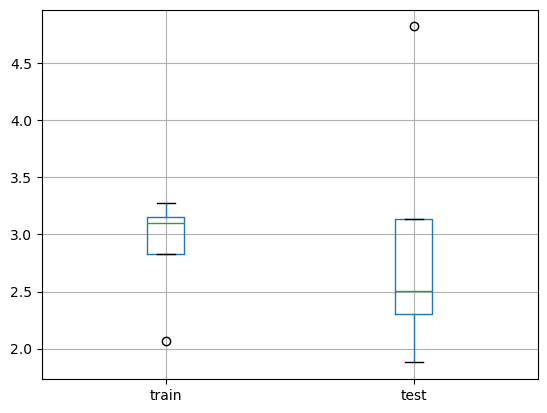

In [135]:
import statsmodels.api as sm 

# Setup a Blank List
rmse_list = []

# Create a series of training and test data sets
for ii in range(0,len(folds)):
    test = folds[0]
    train = pd.concat(folds[1:len(folds)])
    folds.append(folds[0])
    del folds[0]
 
    # Call the OLS function
    
    # Fit
    result = sm.OLS(train.mpg,sm.add_constant(train.wt)).fit()
    
    # Capture training and testing error
    train_rmse = rmse(train.mpg,result.predict(sm.add_constant(train.wt)))
    test_rmse  = rmse(test.mpg,result.predict(sm.add_constant(test.wt)))
    
    # Append the errors to the list
    rmse_list.append([train_rmse,test_rmse])

# Boxplot the resulting training and testing errors
error_frame = pd.DataFrame(rmse_list,columns=['train','test'])

error_frame.describe()
error_frame.boxplot()

The above list structure allow us to drill down into any aspect of the models and predictions we have made for each of the folds. More importantly we can see how well the model works against each of the individual holdout / test data sets. In the end, we just want to be able to look at the average RMSE across the folds. This gives us clues as to how good the model might perform against new data.

<Axes: title={'center': 'Training and Testing Error'}>

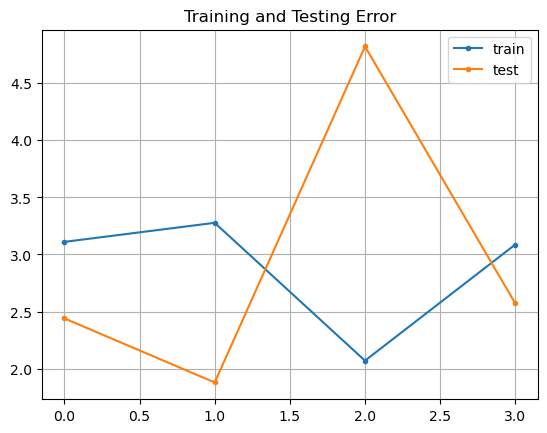

In [136]:
error_frame.plot(kind="line",title="Training and Testing Error", style='.-',grid=True)

## Create A Function To Automate Things

Since we have gone to the trouble of creating a loop structure to process the folds, we could easily turn this into a function to automate the splitting of the data frame across some arbitrary number of folds just to get an idea of how the RMSE looks for different numbers of folds.

We could even have our function accommodate different formula if we wanted but we won’t focus on that right now. You will soon discover that the scikit-learn package does these kinds of things for you but we aren’t quite there yet.

In [137]:
def cross_validator(group_size=4,scramble=1,df=mtcars): 

    # If scramble is 1 then we resample the data frame
    if (scramble == 1):
        tempdf = df.sample(len(df))
    
    # Split the data frame intro groups the size of "group_size"
    lst = [tempdf.iloc[i:i+group_size] for i in range(0,len(tempdf)-group_size+1,group_size)]
    
    # Setup a list to capture the rmse for training and testing
    rmse_list = []

    # Loop through the split dataframe
    for ii in range(0,len(lst)):
        test = lst[0]
        train = pd.concat(lst[1:len(lst)])
        lst.append(lst[0])
        del lst[0]

        # Do regression and figure out rmse for training and test
        result = sm.OLS(train.mpg,sm.add_constant(train.wt)).fit()
        train_rmse = rmse(train.mpg,result.predict(sm.add_constant(train.wt)))
        test_rmse  = rmse(test.mpg,result.predict(sm.add_constant(test.wt)))
          
        # append the data into the list 
        rmse_list.append([train_rmse,test_rmse])
        
        title = "RMSE for " + str(round(len(df)/group_size,2)) + " folds"
        #title = "RMSE for " + str(group_size) + " folds"
        
    return([title,pd.DataFrame(rmse_list,columns=['train','test'])])


<Axes: title={'center': 'RMSE for 4.0 folds'}>

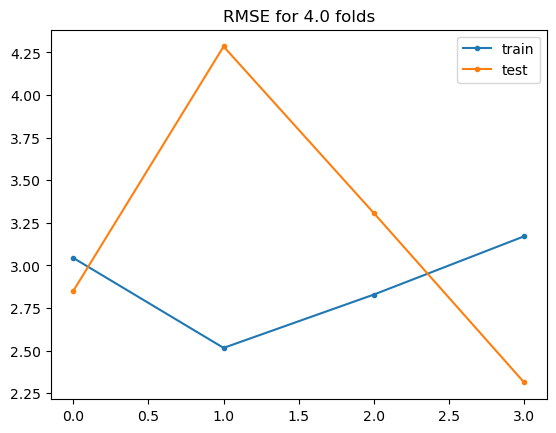

In [138]:
# Now Call the function
title, error_frame = cross_validator(8,1)

# Make a Plot of the Error
error_frame.plot(kind='line',title = title, style='.-')

## Cross Validation

Since we already have an existing function we can up the ante by repeating the cross validation. This will provide more data on how the RMSE might be distributed across multiple runs, each of which does Cross Fold validation. This example will repeat a 4 Fold Cross Validation , 20 times. In the domain of Machine Learning this is known as "Repeated Cross Fold Validation". We can reuse our function from before and add a new argument to it and make a minor adjustment to the coding logic to accomodate this new capability.


In [139]:
def cross_validator(group_size=4,scramble=1,df=mtcars,repeat=10): 

    # Setup a list to capture the rmse for training and testing
    rmse_list = []

    for jj in range(0,repeat):
        if (scramble == 1):
            tempdf = df.sample(len(df))

        # Split the data frame intro groups the size of "group_size"
        lst = [tempdf.iloc[i:i+group_size] for i in range(0,len(tempdf)-group_size+1,group_size)]

        # Loop through the split dataframe
        for ii in range(0,len(lst)):
            test = lst[0]
            train = pd.concat(lst[1:len(lst)])
            lst.append(lst[0])
            del lst[0]

            # Do regression and figure out rmse for training and test
            result = sm.OLS(train.mpg,sm.add_constant(train.wt)).fit()
            train_rmse = rmse(train.mpg,result.predict(sm.add_constant(train.wt)))
            test_rmse  = rmse(test.mpg,result.predict(sm.add_constant(test.wt)))

            # append the data into the list 
            rmse_list.append([train_rmse,test_rmse,jj+1])

            title = "RMSE for " + str(round(len(df)/group_size,2)) + " folds and " + str(repeat) + " repeats"

    return([title,pd.DataFrame(rmse_list,columns=['train','test','repeat'])])


<Axes: title={'center': 'RMSE for 4.0 folds and 10 repeats'}>

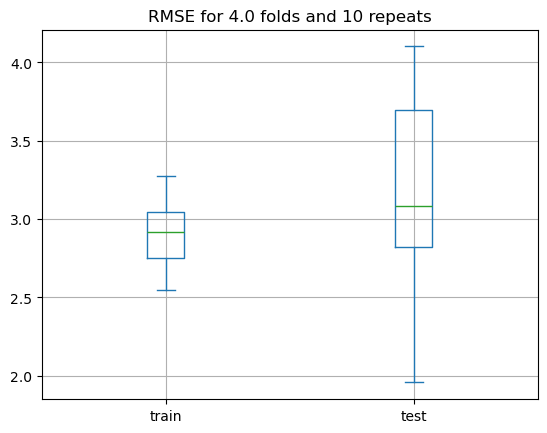

In [140]:
title, error_frame = cross_validator(group_size=8,repeat=10)
error_frame[['train','test']].plot(kind="box",grid=True, title=title)

<Axes: title={'center': 'test'}, xlabel='repeat'>

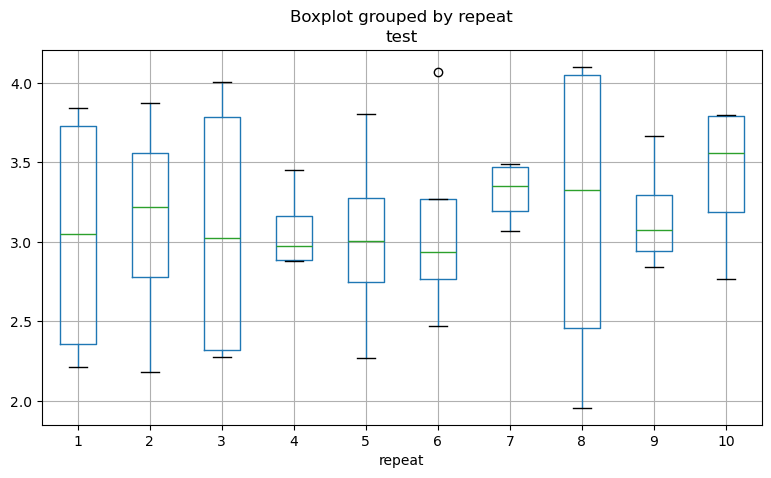

In [141]:
# This shows the test RMSE for each repeat
error_frame.boxplot(column='test',by="repeat",figsize=(9,5)) 

## Bootstrap

An alternative to K-Fold Cross Validation is to use the bootstrap sampling approach which will produce training data sets the same size as the original data set although some observations might be repeated as the sampling process is done with replacement. The observations that do not appear in each of the training sets are then used as a test set. These observations are known as “out of bag samples”. We can alter our existing function to accomodate this form of sampling. But before we do that let me show you what I mean.

### More Info on the Bootstrap

The bootstrap method usually describes a general way to get ideas about a larger collection or population when you have access to a smaller sample of data from the larger population. Think about the heights of everyone in the classroom. If we had no access to anyone else we could use boostrap techniques to perhaps estiamte the average heights of all people outside of the classroom.

What we do is take observations from the our smaller sample data multiple times. We allow for the possibility that we might sample the same observation more than once under the premise that this might well happen in the much larger population. That is, there might be duplicates. So we sample with replacement. To show you how this looks at a baci level then consider the following:

Importantly, samples are constructed by drawing observations from a large data sample one at a time and returning them to the data sample after they have been chosen. This allows a given observation to be included in a given small sample more than once. This approach to sampling is called sampling with replacement.

So here is an example of a basic bootstrap. We have a small list of data values which might well be the only information we could get about a larger popualtion. We can use the idea of sampling N values from the list where N equals the length of the list. We'll sample with replacement as a way to better emulate what we might see in the larger popuation. We don't really know if this is true or not but it's one way to think about the larger population from which this list of numbers came. Lastly, we'll repear this procedure say 1,000 times.

In [142]:
import random

# Example list of numbers
original_data = [23, 45, 12, 67, 89, 34, 56, 78, 90, 43, 99, 23, 88, 79, 54, 21, 47]

# Function to perform bootstrapping on a list of numbers
def bootstrap_sample(data, num_samples=1000):
    bootstrapped_samples = []
    data_size = len(data)

    for _ in range(num_samples):
        # Generate a bootstrap sample by sampling with replacement
        bootstrap_sample = [data[random.randint(0, data_size - 1)] for _ in range(data_size)]
        bootstrapped_samples.append(bootstrap_sample)

    return bootstrapped_samples

# Example of bootstrapping on a list of numbers
bootstrapped_samples = bootstrap_sample(original_data)

# Print a few examples of bootstrapped samples
for i in range(3):
    print(f"Bootstrapped Sample {i + 1}: {bootstrapped_samples[i]}")


Bootstrapped Sample 1: [47, 23, 23, 56, 78, 89, 90, 23, 43, 23, 56, 78, 56, 90, 99, 56, 54]
Bootstrapped Sample 2: [90, 67, 78, 43, 43, 21, 89, 12, 90, 88, 43, 78, 56, 12, 79, 23, 21]
Bootstrapped Sample 3: [45, 45, 23, 99, 23, 47, 78, 47, 23, 90, 79, 79, 79, 78, 67, 89, 43]


We could then use this information to arrive at some idea about the estimate the average of some larger population. We can easily estiamte the average of the list we already have.

In [143]:
# Function to estimate the average using bootstrapped samples
def estimate_average(bootstrapped_samples):
    sample_means = [sum(sample) / len(sample) for sample in bootstrapped_samples]
    average_estimate = sum(sample_means) / len(sample_means)
    return average_estimate

# Calculate the actual average of the original data
actual_average = sum(original_data) / len(original_data)

# Example of bootstrapping on a list of numbers
bootstrapped_samples = bootstrap_sample(original_data)

# Estimate the average using bootstrapped samples
average_estimate = estimate_average(bootstrapped_samples)

# Print the results
print(f"Original Data: {original_data}")
print(f"Actual Average of Original Data: {actual_average:.2f}")
print(f"Estimated Average using Bootstrapped Samples: {average_estimate:.2f}")

Original Data: [23, 45, 12, 67, 89, 34, 56, 78, 90, 43, 99, 23, 88, 79, 54, 21, 47]
Actual Average of Original Data: 55.76
Estimated Average using Bootstrapped Samples: 55.68


### Confidence Interval

We can actually extend this idea to get a confidence interval for the true value of the population mean.

In [144]:
import numpy as np
# Function to create a confidence interval for the mean
def confidence_interval(bootstrapped_samples, alpha=0.10):
    lower_bound = np.percentile(bootstrapped_samples, alpha / 2 * 100)
    upper_bound = np.percentile(bootstrapped_samples, (1 - alpha / 2) * 100)
    return lower_bound, upper_bound

# Calculate the actual average of the original data
actual_average = np.mean(original_data)

# Example of bootstrapping on a list of numbers
bootstrapped_samples = bootstrap_sample(original_data)

# Estimate the average using bootstrapped samples
average_estimate = estimate_average(bootstrapped_samples)

# Create a confidence interval for the mean
lower_bound, upper_bound = confidence_interval(bootstrapped_samples)

# Print the results
print(f"Original Data: {original_data}")
print(f"Actual Average of Original Data: {actual_average:.2f}")
print(f"Estimated Average using Bootstrapped Samples: {average_estimate:.2f}")
print(f"Confidence Interval for the Mean: [{lower_bound:.2f}, {upper_bound:.2f}]")


Original Data: [23, 45, 12, 67, 89, 34, 56, 78, 90, 43, 99, 23, 88, 79, 54, 21, 47]
Actual Average of Original Data: 55.76
Estimated Average using Bootstrapped Samples: 55.70
Confidence Interval for the Mean: [12.00, 99.00]


## Bootstrap for Machine Learning

Well, let's now apply the idea of bootstrap to the idea of training and testing data. We can easily sample some number of records with replacement from mtcars. Below we sample some rows. Note that the argument of **random_state=100** means that this example is reproducible. 

In [145]:
 mtcars.sample(len(mtcars),replace=True,random_state=100)

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
8,22.8,4,140.8,95,3.92,3.150,22.90,1,0,4,2
24,19.2,8,400.0,175,3.08,3.845,17.05,0,0,3,2
3,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
7,24.4,4,146.7,62,3.69,3.190,20.00,1,0,4,2
23,13.3,8,350.0,245,3.73,3.840,15.41,0,0,3,4
15,10.4,8,460.0,215,3.00,5.424,17.82,0,0,3,4
16,14.7,8,440.0,230,3.23,5.345,17.42,0,0,3,4
10,17.8,6,167.6,123,3.92,3.440,18.90,1,0,4,4
30,15.0,8,301.0,335,3.54,3.570,14.60,0,1,5,8
20,21.5,4,120.1,97,3.70,2.465,20.01,1,0,3,1


Here is an easier way to see what gets duplicated as part of this process. You can see that the following rows get duplicated. This is not to be feared because this might well better reflect the larger population of cars. It might be of more concern as to who to determine which rows of the mtcars data frame did not get sampled. That's not hard to do and in face it's those rows that we will use to create the testing data set. 

In [146]:
temp = mtcars.sample(len(mtcars),replace=True,random_state=100)
temp["is_duplicate"] = temp.duplicated()
temp[temp.is_duplicate]

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb,is_duplicate
2,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1,True
2,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1,True
2,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1,True
16,14.7,8,440.0,230,3.23,5.345,17.42,0,0,3,4,True
24,19.2,8,400.0,175,3.08,3.845,17.05,0,0,3,2,True
15,10.4,8,460.0,215,3.00,5.424,17.82,0,0,3,4,True
16,14.7,8,440.0,230,3.23,5.345,17.42,0,0,3,4,True
2,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1,True
27,30.4,4,95.1,113,3.77,1.513,16.90,1,1,5,2,True


In [147]:
temp.groupby('is_duplicate').size()

is_duplicate
False    23
True      9
dtype: int64

So keep in mind that all we are doing is changing ONLY the way in which we sample the data. We are still doing the cross fold validation. Chaning the function is easy to do.

In [148]:
def cross_validator(group_size=4,df=mtcars,repeat=1,boot=True): 

    # Setup a list to capture the rmse for training and testing
    rmse_list = []

    for jj in range(0,repeat):
        
        # If boot 
        if (boot):
            tempdf = df.sample(len(df),replace=True)
        else:
            tempdf = df.sample(len(df),replace=False)

        # Split the data frame intro groups the size of "group_size"
        lst = [tempdf.iloc[i:i+group_size] for i in range(0,len(tempdf)-group_size+1,group_size)]

        # Loop through the split dataframe
        for ii in range(0,len(lst)):
            test = lst[0]
            train = pd.concat(lst[1:len(lst)])
            lst.append(lst[0])
            del lst[0]

            # Do regression and figure out rmse for training and test
            result = sm.OLS(train.mpg,sm.add_constant(train.wt)).fit()
            train_rmse = rmse(train.mpg,result.predict(sm.add_constant(train.wt)))
            test_rmse  = rmse(test.mpg,result.predict(sm.add_constant(test.wt)))

            # append the data into the list 
            rmse_list.append([train_rmse,test_rmse,jj+1])
            
            if (boot):
                title = "RMSE for " + str(round(len(df)/group_size,2)) + " folds and " + str(repeat) + " repeats - bootstrapped"
            else:
                title = "RMSE for " + str(round(len(df)/group_size,2)) + " folds and " + str(repeat) + " repeats"

    return([title,pd.DataFrame(rmse_list,columns=['train','test','repeat'])])


In [93]:
title, error_frame = cross_validator(group_size=8,repeat=10,boot=True)
error_frame

,train,test,repeat
0,2.940,3.370,1
1,3.124,2.798,1
2,2.793,3.607,1
3,3.018,3.010,1
4,3.001,3.342,2
5,3.103,3.050,2
6,3.155,3.049,2
7,2.862,4.039,2
8,2.918,3.684,3
9,3.104,3.456,3


In [149]:
error_frame[['train','test']].describe()

,train,test
count,40.000000,40.000000
mean,2.906450,3.151900
std,0.192642,0.603783
min,2.549000,1.957000
25%,2.748750,2.823000
50%,2.915500,3.085000
75%,3.044500,3.699250
max,3.277000,4.102000


Text(0.5, 1.0, 'RMSE for 4.0 folds and 10 repeats')

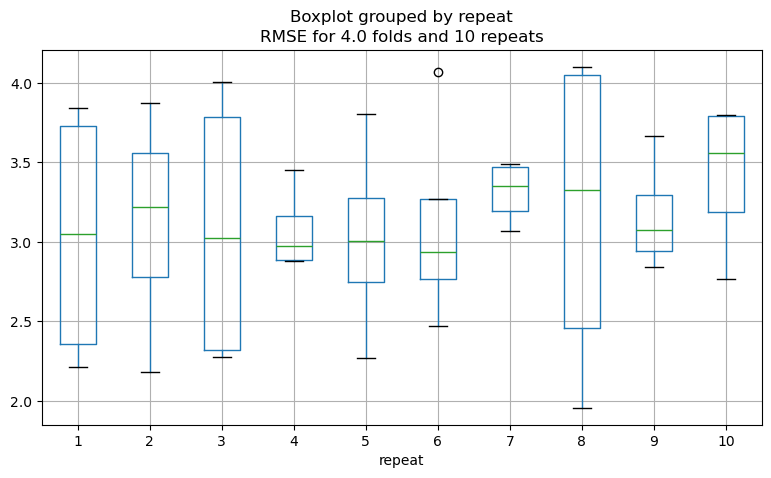

In [150]:
import matplotlib.pyplot as plt
error_frame.boxplot(column=['test'],by="repeat",figsize=(9,5)) 
plt.title(title)

If we wanted to look at the distribtuion of Test RMSE across all booststrapped repeats 

Text(0.5, 1.0, 'Test RMSE for 4.0 folds and 10 repeats')

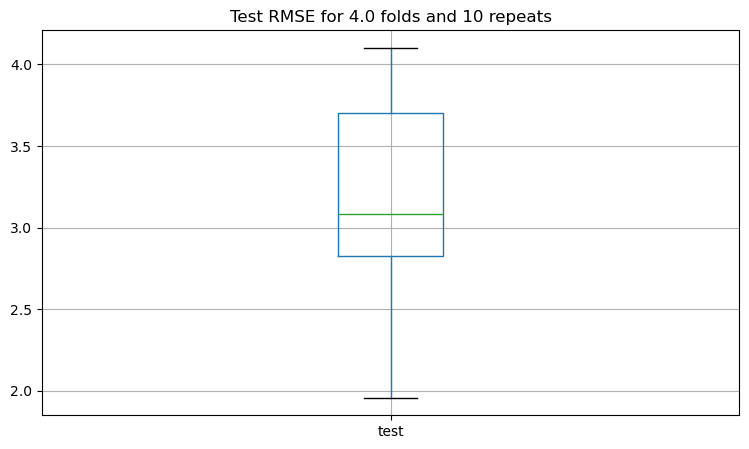

In [151]:
error_frame.boxplot(column=['test'],figsize=(9,5)) 
plt.title("Test " + title)

How does this compare to a non-bootstrapped cross fold vslidation ?

In [152]:
title, error_frame = cross_validator(group_size=8,repeat=10,boot=False)
error_frame

,train,test,repeat
0,2.897,3.699,1
1,2.604,3.900,1
2,3.004,2.885,1
3,3.073,2.570,1
4,2.329,4.639,2
5,3.186,2.322,2
6,2.730,3.688,2
7,3.230,1.914,2
8,2.856,3.407,3
9,2.632,3.826,3


Text(0.5, 1.0, 'Test RMSE for 4.0 folds and 10 repeats')

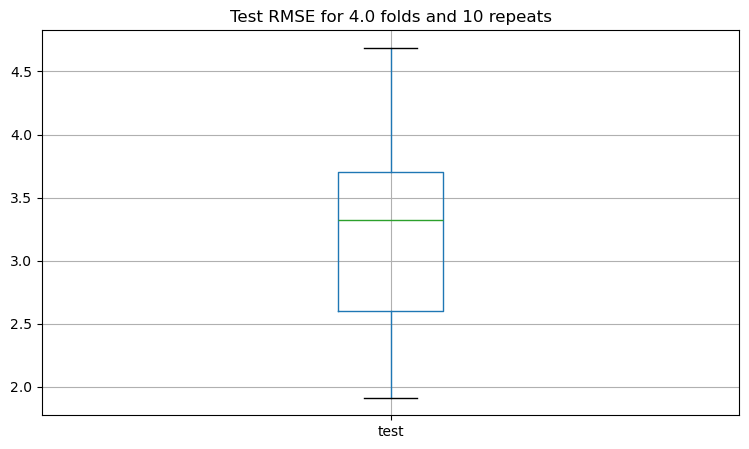

In [153]:
error_frame.boxplot(column=['test'],figsize=(9,5)) 
plt.title("Test " + title)

We've done a lot here including last week. We've implemented our own methods for creating training and test data as well as ways to assess the training and test error. We could continue in this direction although as you will soon discover, there are easier ways to do this which will allow us to focus on building better models as opposed to segmenting data. 